## Long Short-Term Memory (LSTM) neural network model

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
SAVING_DIR = r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\outputs\models'

import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import sklearn.metrics as metrics # for model evaluation 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
df_by_hour = pd.read_csv(r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\data\processed\cleaned_df_final.csv').drop(['index'], axis=1)
df_by_hour.head(2)

,date,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
0,2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
1,2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [3]:
df_by_hour.set_index('date', inplace=True)
df_by_hour.head(2)

,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,0.000708,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,0.000517,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [4]:
# sub-selecting data 
df_by_hour= df_by_hour.loc['2019-03':'2019-06']
df_by_hour.drop(['Day'], axis=1, inplace =True)

In [5]:
df_by_hour.columns

Index(['Pressure', 'Humidity', 'Temperature', 'NO_s', 'NO2_s', 'O3_s', 'CO_s',
       'NO', 'NO2', 'O3', 'CO', 'Hour', 'Day_of_week', 'Day_of_month', 'Month',
       'is_weekday', 'daypart', 'Season', 'NO_lag_feature', 'NO2_lag_feature',
       'CO_lag_feature', 'O3_lag_feature', 'NO_rolling_mean',
       'NO2_rolling_mean', 'CO_rolling_mean', 'O3_rolling_mean',
       'NO_rolling_min', 'NO2_rolling_min', 'CO_rolling_min', 'O3_rolling_min',
       'NO_rolling_max', 'NO2_rolling_max', 'CO_rolling_max', 'O3_rolling_max',
       'NO_rolling_std', 'NO2_rolling_std', 'CO_rolling_std',
       'O3_rolling_std'],
      dtype='object')

### Machine learning data preparation 

In [6]:
# Spliting the data into train and test sets
train_size = int(len(df_by_hour)*0.8)
test_size = len(df_by_hour) - train_size

train, test = df_by_hour.iloc[0:train_size], df_by_hour.iloc[train_size:len(df_by_hour)]

print(train.shape, test.shape)

(1761, 38) (441, 38)


In [7]:
# Scaling of data

# creating variables for list of columns with scaler
feature_columns = ['Pressure', 'Humidity', 'Temperature','NO', 'NO2', 'CO',
         'NO_s', 'NO2_s','O3_s', 'CO_s', 'Hour','Day_of_week', 'is_weekday', 'daypart',
        'NO_rolling_mean', 'NO2_rolling_mean', 'CO_rolling_mean',
        'O3_rolling_mean', 'NO_rolling_min', 'NO2_rolling_min',
        'CO_rolling_min', 'O3_rolling_min', 'NO_rolling_max', 'NO2_rolling_max',
        'CO_rolling_max', 'O3_rolling_max',
        'O3_rolling_std']
#target_columns = ['NO']

feature_transformer = MinMaxScaler()
NO_transformer = MinMaxScaler()

# fit the scaler on training data
feature_transformer = feature_transformer.fit(train[feature_columns])
NO_transformer = NO_transformer.fit(train[['NO']])

In [8]:
train.loc[:, feature_columns] = feature_transformer.transform(train[feature_columns])
train['NO'] = NO_transformer.transform(train[['NO']])

test.loc[:, feature_columns] = feature_transformer.transform(test[feature_columns])
test['NO'] = NO_transformer.transform(test[['NO']])

In [9]:
# Making the time series data into sub sequences by writing a funciton
# split a multivariate sequene into samples
import numpy as np 
def create_dataset(X, y, time_steps=1): # X=features, y=labels, time_steps= history of sequence
    Xs, ys = [], [] # create two lists
    for i in range(len(X) - time_steps): #loops for the subsequent steps
        values = X.iloc[i: (i + time_steps)]
        Xs.append(values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#x = np.asarray(x).astype('float32')
#x_train = np.asarray(x_train).astype(np.float32)
#y_train = np.asarray(y_train).astype(np.float32)

In [10]:
# Specify number of time steps
TIME_STEPS = 48 # history of 24 hours to predict for the next 24 hours

# Creating actual taining and test dataset
# Reshaping to samples, time_steps and n_features
X_train, y_train = create_dataset(train, train.NO, time_steps= TIME_STEPS)
X_test, y_test = create_dataset(test, test.NO, time_steps= TIME_STEPS)

In [11]:
# printing number of samples, number of time_steps and number of features
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1713, 48, 38) (1713,)
(393, 48, 38) (393,)


In [44]:
# print the first sequence
#X_test[0].shape
X_test[0][0].shape, X_train[0][0].shape

((38,), (38,))

In [12]:
# Creating function for deep learning model

def create_model(optimizer='adam', dropout_rate=0.2, activation='relu'):
    model_lstm = keras.Sequential()

    model_lstm.add( keras.layers.LSTM(units = 128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(keras.layers.Dropout(rate=0.2))# add dropout layer

    model_lstm.add(keras.layers.Dense(units=1))

    # compile the model
    model_lstm.compile(loss='mean_squared_error', optimizer='RMSProp')
    
    return model_lstm


model_lstm = create_model()
model_lstm.summary()

# Saving the model
my_path = SAVING_DIR
my_file = "model_lstm.h5"
model_lstm.save_weights(os.path.join(my_path, my_file))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               85504     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 85,633
Trainable params: 85,633
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
seed = 7 # fix random seed for reproducibility
np.random.seed(seed)

lstm_history = model_lstm.fit(X_train, y_train, 
                        epochs = 30,
                        batch_size=32,
                        validation_split=0.3,
                        shuffle=False
                       )

Train on 1199 samples, validate on 514 samples
Epoch 1/30
1199/1199 [==============================] - 4s 4ms/sample - loss: 16381.4112 - val_loss: 114.5078
Epoch 2/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 66.5396 - val_loss: 14.7283
Epoch 3/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 62.8462 - val_loss: 26.0885
Epoch 4/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 18.3396 - val_loss: 1.3482
Epoch 5/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 5.3194 - val_loss: 1.1179
Epoch 6/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 10.6788 - val_loss: 0.8523
Epoch 7/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 3.1358 - val_loss: 0.9064
Epoch 8/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 4.5601 - val_loss: 0.6858
Epoch 9/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 1.8273 - val_loss: 0.5850
Epoch

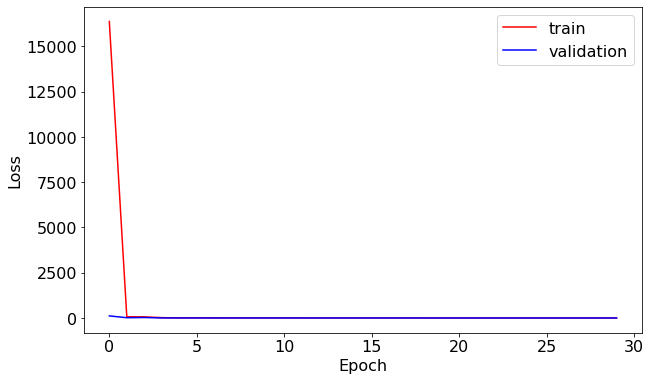

In [14]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(lstm_history.history['loss'], 'r', label='train')
plt.plot(lstm_history.history['val_loss'], 'b', label='validation')
ax.set_xlabel(r'Epoch', fontsize=16)
ax.set_ylabel(r'Loss', fontsize=16)
ax.legend(fontsize = 16)
ax.tick_params(labelsize=16)


# Save the plot
my_path = SAVING_DIR
my_file = 'LSTM_model_NO.png'
plt.savefig(os.path.join(my_path, my_file))

In [15]:
# making prediction
y_pred_lstm = model_lstm.predict(X_test)

In [16]:
# function for calculating MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))*100

# Model evaluation using mean square error (MSE)
print('r Squared Error:' , metrics.r2_score(y_test, y_pred_lstm))
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred_lstm))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_lstm)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_lstm))
print('MAPE:' , mape(y_test, y_pred_lstm))

r Squared Error: 0.8594252951101214
Mean Squared Error: 0.5995781457575633
Root Mean Squared Error: 0.7743243156181803
Mean Absolute Error: 0.500292025730093
MAPE: 151.00845671226517


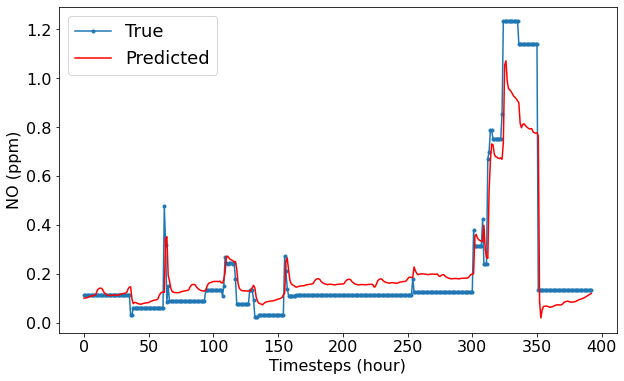

In [17]:
# use inverse the scaler for the feature variable
# invert the X_train, y_train and predicted data
y_train_inv = NO_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = NO_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = NO_transformer.inverse_transform(y_pred_lstm)

# plotting the predicted value
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(y_test_inv.flatten(), marker='.', label='True')
plt.plot(y_pred_inv.flatten(), 'r', label='Predicted')

ax.set_xlabel(r'Timesteps (hour)', fontsize=16)
ax.set_ylabel(r'NO (ppm)', fontsize=16)
ax.legend()
ax.tick_params(labelsize=16)
#plt.ylabel('Global_active_power', size=15)
#plt.xlabel('Time step', size=15)
plt.legend(fontsize=18)

my_path = SAVING_DIR
my_file = 'LSTM_prediction_NO'
plt.savefig(os.path.join(my_path, my_file), dpi=300, bbox_inches='tight')

### Tunning hyperparameter using cross vlaidation : by using GridSearchCV from Scikit-Learn

In [19]:
%%time
seed = 7 # fix random seed for reproducibility
np.random.seed(seed)


# create the sklearn model for the network
model_batch_epoch = KerasRegressor(build_fn=create_model, verbose=1)

# we choose the initializers that came at the top in our previous cross-validation!!
#init_mode = ['glorot_uniform', 'uniform'] 
#layer_size= [32, 64, 128]
batches = [16, 32, 64]
epochs = [20, 30, 40]
#learn_rate= [0.001,0.01, 0.1 ]
dropout_rate=[0.2, 0.3]
optimizer=['Adam', 'RMSProp']
#activation=['sigmoid', 'relu']

# grid search for initializer
param_grid = dict( batch_size=batches, epochs=epochs, dropout_rate=dropout_rate, optimizer=optimizer)
grid = GridSearchCV(estimator=model_batch_epoch,
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(X_train, y_train)

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 96370307.7839
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 121164459496.9527
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 45889855763.0543
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2727820988.2172
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1312857066.1016
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 433938319.9159
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 8924236277.1278
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4178331433.6953
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4054128513.0088
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 663054056.7846
Epoch 11/20
1142/1142 [===============

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 440368086771.8161
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 64689067463.7557
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 643567765.9475
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 8489318878.2277
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 762489968.8687
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 980829481.1265
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 80024758.7320
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - lo

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.9928
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8818
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6543
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5657
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4785
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4747
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4427
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4044
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3863
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4037
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3910
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 37623905995.2016
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 11226517461.7303
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 6998455766.6200
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 9754259661.0578
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 8541243663.8599
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 558753148.8967
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3098296987.0219
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 854908996.3783
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 86894747.0543
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 23916878.0245
Epoch 11/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 2643511.0563
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 740303676.2599
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 496377699.7688
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 544276086.5079
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 952301885.3660
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1682616153.7513
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 495770738.4939
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 529233124.5744
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 17075849118.9912
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1540351263.1313
Epoch 11/20
1142/1142 [======================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 2986.9929
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 7.6610
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 53.9658
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9982
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3478 0s - l
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8720
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6785
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5722
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4936
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4763
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4408
Epoch 12/20
1142/1142 [=======

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 113.3575
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3582
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2018
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8108
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6603
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5892
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5245
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5316
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4770 0s - loss: 0
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4256 0s - loss: 0
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3950
Epoch 12/30
1

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 5601303695.8749
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 79.5232
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 14.6933
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0647
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1554
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9070
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6778
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5672
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 24877364.1891
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 46.2248
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 5.5210 0s - loss: 6.
Epoch 12

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 161.5048
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4.9579
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.4403
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 25.4002
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1687
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9476
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6626
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5973
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5681
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5044
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4669
Epoch 12/30
1142/1142 [===============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 724946370.0830
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 385215588.7075
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 811486808.6620
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 658054665.1270
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 50607967959.8862
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 17075605040.0841
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4252732613.6532
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 273503636.0806
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1140600857.9264
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 125873648.9177
Epoch 11/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 366.6003
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7032
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.5167
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0452
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6311
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4633 0s -
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3939
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3573
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3072
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2969
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2774
Epoch 12/30
1142/1142 [===========

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 23314.8656
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 708697.6478
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 52074509.0615
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 567777.1687
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1193648.4365
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 10748324.1134
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 43101227.6159
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2383545188.6515
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 374502572.2767
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 134512606.2417
Epoch 11/30
1142/1142 [==============================] - 2s 2

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 109722.7869
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 612250789.5352
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 5152103374.4588
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1375110193.8214
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 682045723.5293
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 4972140.5554 0s - l
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 481854.2468
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 37986.1709
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 45413883.4897
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2449441805.4466
Epoch 11/40
1142/1142 [===========================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 130.1344
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.3864
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8655
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5518
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4712
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3721
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3140
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3275
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2824
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2646
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2556
Epoch 12/40
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 21181.4564
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 109.5458
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 60.3004
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.8989
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4352
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9724
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7315
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6409
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5347
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4991
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5504
Epoch 12/40
1142/1142 [===========

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1848538.3555
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1379437.7748
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 574924.9426
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 445691.8572
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 202477.4557
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3719.3904
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 49.7001
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 6.7902
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0218
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1136
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.8967
Epoch 12/4

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 7665944.3827 1s - loss: 8
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 4287465.3856
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 5933149351.3288
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1595284609.8494
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 181605602358.0420
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 9210076910.0105
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1608505636.3713
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 905563073.0455
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1247383807.3135
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 68146216.8666
Epoch 11/40
1142/1142 [========

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1224141.4586
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1919.5419
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 17.3335
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.8366
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 9.7807
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2286
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8941
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6121
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5558
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5056
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4727
Epoch 12/40
1142/1142 [========

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1023.7453
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8085
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0419
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0139
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.7473
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6353
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5368
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5241
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4527
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6318
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3816
Epoch 12/20
1142/1142 [===============

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 123048970.9253
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 25817783.4768
Epoch 3/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 5995218.9842
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 40079612.8924
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 190.7741
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 6.7609
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8683
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0840
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7877
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6105
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4542
Epoch 12/20

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 803001453.7553
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 6005129.8327
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 414601.4200
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 9906572832.2435
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 73676629.3592
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 342863292.5814
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 50346747232.3468
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 24574531610.4527
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2910025.8525
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4833012.6401
Epoch 11/20
1142/1142 [=============================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 315475769.4250
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 32841758.8687
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 12565795.9124
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 7626741.2038
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1256980.5864
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1328801.8215
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2214.3868
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 25512.7548
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 146.1756
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 399797.9336
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - 

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 2491.4666
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 283333682.0981 0s - loss: 298008
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 15834738.6252
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4081416.6061
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 84182910.8954
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 89820482.4378
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 271410051.5306
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 168855474.2277
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 252325775.3993
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 29629078.0144
Epoch 11/20
1142/1142 [=================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 5s 4ms/sample - loss: 157.8754
Epoch 2/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.9689
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.6727
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.8847
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.8933
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6690
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5890
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5513
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4898
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4534
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5900
Epoch 12/20
1142/1142 [================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 2549647048.1493
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1097503237.8737
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 573631699.0070
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 26335110.9054
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 7643920.9124
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 12096234.8423
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 22349824.3266
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 17158350.2521
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 151159262.9046
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 943922.7685
Epoch 11/30
1142/1142 [==============================]

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 67.8149
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7800
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 21.35780s - loss: 21.38
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.5871
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8359
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6439
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4303
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3636 1s  - ETA: 0s - 
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3247
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3027
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3123
Epoch 

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 7.9975
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1343
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8054
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6523
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5415
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5098
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4737
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4305
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3896
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3921
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3795
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 82485.7907
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 119334.1353
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 120486.3703
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 59981.9510
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 316062934.9515
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1811.9502
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 19.3138
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4.4563
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.1208
Epoch 10/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.2350
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9508
Epoch 12/30

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 541224.2855
Epoch 2/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 623789449.3774 - ETA: 0s - loss: 65433
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 147647663.6497 0s - loss: 156535432.
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 53877649.5714
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2085440.0783
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 288265.5496
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 23534.0122
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 251.7501
Epoch 9/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 71.9428
Epoch 10/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 3.3548
Epoch 11/30
1142/1142 [============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 2882308.3645
Epoch 2/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 5656949.0059
Epoch 3/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 162632581.2266
Epoch 4/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 45420370.2929
Epoch 5/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 3485645140.4729
Epoch 6/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 5212072478.0385
Epoch 7/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 25001796634.7741
Epoch 8/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 761665040.6865
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 508027871932.0771
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 89805908585.3590
Epoch 11/30
1142/1142 [====================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 28.9780
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4070
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9447
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7040
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5897
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5420 0s - l
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4990
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4572
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4371
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3882
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4015
Epoch 12/40
1142/1142 [==========

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 791704.7959
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 11810.7497
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2587.0328
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 573.0157
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 5.4131
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.3787
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.9299
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5921
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4794
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3784
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3297
Epoch 12/40
1142/1142 [====

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 4557.2510
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 6143.3728
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 260.2227
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 236.7812
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 43547743584.6702
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1444513648.0000
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 382954584.1891
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 109808443.5279
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 29544625.1786
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1230076047696.2661
Epoch 11/40
1142/1142 [==============================] - 3s 2ms

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 256.2786
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 6.3854
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8029
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2635
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9786
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7505
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6357
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5495
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5109
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5135 0s - loss: 
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4586
Epoch 12/40
1142/1142 [====

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 47.0686
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.4427
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6477
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4531
Epoch 5/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.3863
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3717
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3163
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3011
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2911
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2611
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2599
Epoch 12/40
1142/1142 [=================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 252561.8596
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 43993208.0497
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 34524657.7198
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 5415146.3245
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 66657727.2198
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1842759.6427
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 168471631899040.0000
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 18362039316.8476
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 3368051043515.7407
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 263686924.5105
Epoch 11/40
1142/1142 [======================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 6412.7151
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 581.5138
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 10852.9870
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 430.9351
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 433.1913
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 6.4536
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.3992
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.2039
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7312
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2254
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.0174
Epoch 12/20
1142/1142 [=====

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 33.2048
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 3.3253
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.9909
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.5638
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1867
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.9601
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7240
Epoch 8/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 0.6714
Epoch 9/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 0.5121
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4613
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4186
Epoch 12/20
1142/1142 [=================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 10.5248
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4029
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0209
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9236
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7482
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6290
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6031
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5746 0s - 
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4910
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5156
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4574
Epoch 12/20
1142/1142 [===========

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 215211.9016
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 63640.3635
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2363.0841
Epoch 4/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 911.0967
Epoch 5/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 355.4054
Epoch 6/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 107.3352
Epoch 7/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 5.1515
Epoch 8/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.1345
Epoch 9/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.4541
Epoch 10/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.2185
Epoch 11/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 0.9608
Epoch 12/20
1142/1142 [

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 354.4867
Epoch 2/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 21.2477
Epoch 3/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.2931
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.6838
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.3787
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.8003
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6731
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5731
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4312
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4292
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3537
Epoch 12/20
1142/1142 [===============

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 130259409.5770
Epoch 2/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 10060345.0298
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 6875198.3824
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 73795.9057
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 62992.2949
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 30612.2512
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 3217674.4633
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 40358.1344
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 28975.4511
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4742.3552
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 5086065.0951
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 45416007.1313
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 62061756.0701
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 23092169.5201
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 31352522607.8319
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 144483044407.5937
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 68534193245.7023
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 196682253.6900
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 49203336.7075
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 113616872.4834 1s - lo
Epoch 11/30
1142/1142 [===============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 2002.6146
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 997.5799
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 204.4160
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 133.4350
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 9356.3844
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 2628.0228
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 3165.7312
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1866.1358
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 985.0475
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1377.6272
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 484.9155
Epoch 12/30
1

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 1494.2518
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 9.4071
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.3883
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.5436
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2661
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9434
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.8422
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7049
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6175
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 24.7626
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5078
Epoch 12/30
1142/1142 [==============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 87035.5770
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 21758650.5254
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 97201593.5271
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 22933575564.0490
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 278337699294.8231
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 56114759285.4641
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 20971341712.5889
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4256908479.8879
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 459426195.5306
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 154704638.3562
Epoch 11/30
1142/1142 [====================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 12669544823.8859
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1228167204.4273
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 827565111.5937
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 7825697792.8967
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1683002237.5342
Epoch 6/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1001466137.3310
Epoch 7/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 335832071.9019
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 115610006.6865
Epoch 9/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 15373412.7968
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 645328573.8704
Epoch 11/30
1142/1142 [===================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 6774764.2881
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 268807.4894
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1723511.3969
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 29789482.8231
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 254427821.6602
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 214472974.7741
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 107063307.4466
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 5972683.4343
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 734.0859
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 20209.3766
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sam

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1386828.5530
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 7122568.6473
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 16076535326233.1074
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 16415511740530.7734
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 6371641908717.1699
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1620434933440.7847
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 161120913649.7443
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1234645982.7110
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 38640233518.4028
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 7653270635.6007
Epoch 11/40
1142/1142 [===

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 943.6999
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 75.4754
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 21.0775
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 8.7638
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 5.8415
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.8665
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8922
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4572
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9296
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8134
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5561
Epoch 12/40
1142/1142 [==============

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 74.8220
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 6.8174 0s - l
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.9807
Epoch 4/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.3367
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1395
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8340
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8444
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6939
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6007
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5462
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5886 1s -
Epoch 12/40
1142/1142 [=====

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 537.0775
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 80.5363
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 10.5462
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.7177
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.2512
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3908
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.4540
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.8771
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 428362751.2893
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 14126.1902 0s - loss: 15687.1
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 306.6128
Epoc

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 85.5718
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.0791
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.9265
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.0975
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.8535
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6452
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5723
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5355
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4030
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3774
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3500
Epoch 12/40
1142/1142 [=================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 666560.1163
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1081216.3264
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 505148.7077
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 374369.0458
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 15288567.8226
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 62574468.6668
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 3357728.2255
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 604573.3585
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 23605637.8743
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 59395925.2750
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sam

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 4602.7182
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1393.3755
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 80002.6276
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 24009.7751
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 107.0848
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 11.1850
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 6.0295
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 3.3741
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3645
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.4741
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.2163 0s - loss: 2.
Epoch 12/2

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 479821.5413
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 332817.2869
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 917147.1990
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 399670.2523
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 214640614.6814
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 28605773.3818
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2627271.7524 0s - loss: 2646957.993
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 65988031.7329
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 33576694.8047
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2384133.6533
Epoch 11/20
1142/1142 [====================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 14625449.7412
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 6271083.1016
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 3185756.9063
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 887382.6947
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1614.2543
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 571.2642
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 154.1326
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 37.0781
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 16.1613
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.8155
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.5862 0s - lo


Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 2374165.7333
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 19426278.6445
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 20928370.4247
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 11364008.8450
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 876033.3433
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 263312.6837
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 288126053.9383
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 378591484.3975
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 72684787.0648
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4285394.1000
Epoch 11/20
1142/1142 [==============================] - 2s 1

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 15639982.6691
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2602967.1283
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 959274.0685
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 515545.3094
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 281421.8649
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 89708559595.2785
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 54457302.9562
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 39677815.0123
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 42305204.2820
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 184132739.4676
Epoch 11/20
1142/1142 [==============================] - 2s 

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 7.1329
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.8533
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.3528
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.1262
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7874
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6549
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5763
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5744
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4705
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4593
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4424
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 562106737.2390
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 274318160.9667
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 56980977.5271
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 9682776.5849
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 5699973.1844
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 14799838.9930
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 56714125.8004
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 78881044.1821
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 22283926.9921
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 403092554.6060
Epoch 11/30
1142/1142 [==============================] -

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 66043193.1351
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 74260351.2067
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 62643627.2164
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 18373.4093
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 5206.0303
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 6381.3750
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 6497.6010
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 4751662.3096
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 11827069.7636
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 8261259.8757
Epoch 11/30
1142/1142 [==============================] - 2s 1ms/sample - l

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1410386998.6948
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2484956525.6182
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 15850682671.5236
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 588088166.5560
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 347064967.7968
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1490403039.9720
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 341663392.7285
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 224865049.5933 0s - loss: 31875
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 49665364.82750s -
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 285273826.3231
Epoch 11/30
1142/1142 

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 9684175.1717
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 108983.5270
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 33758.3272
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 6121.7154
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 21133353.8317
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 20910714.3538 ETA: 0s - loss: 16987
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 186749328.1073
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 612529948.1821
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 687622416.3187
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 16416460.5665
Epoch 11/30
1142/1142 [===================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 12286528.7303
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 35377.1151
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 17568.5065
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 12262.1965
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 7776.6726
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 3799.4462
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 187.6724
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 50.0746
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 11.2820
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.9961
Epoch 11/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.5935
Epoch 12/30


Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 27.6572
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 25.1029
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 4.2790
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 3.1932
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.1911
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 287.0761
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 790721.3041
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 104706.2156
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 85774.0533
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 105456.0021
Epoch 11/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 59581.0360
Epoch 12/30
11

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 370.7249
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 8.3857
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 8.1304
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.1644
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.1582
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.9673
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4287
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1763
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1168
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7943
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6925
Epoch 12/40
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 7307.8222
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 237.7998
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 275690.9488 loss: 
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 16886212.2296
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 853378.1077
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 62137.1482
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 43748388796.2771ss: 28 - ETA: 0s - loss: 150034
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 14928202075.0123
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2841221448.2942
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 47341464056.9387
Epoch 11/40
1142/1142 [=

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 3512.1989
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1128928867.1270
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 53004438935.0893
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 53137747404.8897
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 4390380997.0771
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1846731.5453 1s -
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 744430.7537
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 72292.5877
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 12475986.3783
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 24092988.6610
Epoch 11/40
1142/1142 [=============================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 48001.5911
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 8809213.4251
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1330856.9014
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 270123.8602
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 34.3774
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 7.3962
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 4.1609
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9420
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 860558.3522
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 126333460.6095
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 68708347.5420

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 2081.6217
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 299.2368
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 26.3895
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 3.8835
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4103
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1131
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8733
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6862
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5658
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4905
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4345
Epoch 12/40
1142/1142 [============

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 236750.9316
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 86972.1536
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 11232311.14190s - loss: 11054296.
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 5302530845.0473
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 109107925.2189
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 144625870.5429 0s - loss: 162
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 6824102827.7916
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3852155258.3958
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 11551553053.2539
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 234758738.9422
Epoch 11/40
114

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 3633897.4611
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2440142.6333
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1503959.1876
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1089561.3139
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 989368.6587
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 604552.2070
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 513964.0790
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 354844.3399
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 180514.2217
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 144905.4701
Epoch 11/20
1142/1142 [==============================] - 3s 2ms/sample - 

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 13s 11ms/sample - loss: 18.2705
Epoch 2/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.7606
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3716
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0637
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9354
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7517
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5900
Epoch 8/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5142
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4425
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4422
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4240
Epoch 12/20
1142/1142 [===============

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 129.2247
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.2778
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.5744
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.1089
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7317
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3955
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2644
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1352
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9796
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7506
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8028
Epoch 12/20
1142/1142 [================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 3334.7571
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1633.7806
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1025.3202
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 813.9946
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 481.7204
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 8316871.3655
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 35609818.3818
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 16255756.7426
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 10752238.50700s - loss: 10986845.
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 8970439.5552
Epoch 11/20
1142/1142 [==============================] - 2s 2

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 465.5435
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 54.3442
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 8.4656
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8928
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4670
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2594
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9282
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0581
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7644
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6418
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8569
Epoch 12/20
1142/1142 [===============

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 2453.1448
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 979.1214
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 21111.2612
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 13927.0514
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1488.5464
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1272.5426
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1143.8531
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 163.0267
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 62.4271
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 37.5363
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 23.8944
Epoch 12/20
11

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1140.2910
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 158289.7661
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 157218.7699
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 23943.1833
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1633.9227
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1064.7346
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 737.6994
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 662.2251
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 7454.8326
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 38786168.2215
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 92795333.50

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 29137.2582
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 32781.1500
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 687775.5792
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4195577.3643
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1957199.4634
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1292130.9019
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 14628899384468.1738
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 9353987090607.7480
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2426694742525.3101
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1626866488077.8984
Epoch 11/30
1142/1142 [========================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 778.9576
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 145.3667
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 101.7024
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 21.7083
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4.4779
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.5554
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9621
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.6628
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4218
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4748
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1690
Epoch 12/30
1142/1142 [===========

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 2177060148.2915
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 32403878187.9229
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 15951750136181.0176
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 221671480153.2189
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 176609334517.6883
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 125595224383.2154
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 174810683531.8809
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 237977673914.5079
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 937006775373.1138
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 677551691632.5323
Epoch 11/30
1142/1

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 3476.7623
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 199.4143
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 251.6490
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 358.0347
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 48.3820
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 16.1491
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 8.8334
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.5712
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7993
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4103
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1600
Epoch 12/30
1142/1142 [=======

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 170851619285.9797
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 906515368900.8196
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 326940278009.2750
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 141155904897.5692
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 82512090103.0333
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 37175326684.1331
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2707718044.4694
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1938713043.1664
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 7225813772.1051
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 6656398830.9632
Epoch 11/30
1142/1142 [====

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 49146.0045
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 18361.8032
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 14499.8357
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 11105.3614
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 9849.4687
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 8668.2376
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 5859.1002
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 4217.9808
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2576.5618
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1373.9628
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 717.8653
Epoch

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 203.1228
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 5.6289
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.7497
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7468
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.6693
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.6865
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3332
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2255
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1009
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9304
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7661
Epoch 12/40
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 15.5381
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.4365
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9058
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.6493
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4126
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0117
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0384
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8552
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7935
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6358
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6799
Epoch 12/40
1142/1142 [=================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 29.7820
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8272
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3072
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1066
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2348
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0016
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3352
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8734
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7080
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7498
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8215
Epoch 12/40
1142/1142 [=================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1641253.6428
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1289561.8573
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1118090.0190
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 762422.3969
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 298038.3029
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 129935.4079
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 26990.1582
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 192083.8531
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 374087.2226
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 190341.9167
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - lo

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 27.2430
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.2083
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.6732
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3916
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.1311
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0627
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8456
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8692
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7234
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6905
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6223
Epoch 12/40
1142/1142 [=================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 25548289.6346
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 20316549.4221
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 127098698.9562
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 555044606.9912
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 717510656.2242
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 398273388.6935
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 390584917.7443
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 245554144.2242
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 201408130.1856
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 198297715.3905
Epoch 11/20
1142/1142 [==========================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 5s 4ms/sample - loss: 2759405.0742
Epoch 2/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 42073368.1064
Epoch 3/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 8988829687.9299
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 2305551200.8406
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 2770371651.6988
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 2928023736.0420
Epoch 7/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1406810965.7443
Epoch 8/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 394610334.2197
Epoch 9/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1467791.4308
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1267215.7010
Epoch 11/20
1142/1142 [==========================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 271328.4917
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1414414.1689
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 466147.9328
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 62651861.1068
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 35740945.5088
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 19080622.1086
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 443309007.3555
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 475367758659.6988
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 200273463543.4816
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 159417242898.3818
Epoch 11/20
1142/1142 [==========================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 8541.8263
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4675.9281
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4076.6906
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 566.8265
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 457.9338
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 160.1268
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 63.2980
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 33.5105
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 23.7606
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 24.2967
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 6.5411
Epoch 12/20
1142/1142 

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 5s 4ms/sample - loss: 100666.2881
Epoch 2/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 48793.1409
Epoch 3/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 27098.9819
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 17803.6987
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1976.7789
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1123.5463
Epoch 7/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 256173.6998
Epoch 8/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 2114987140789.1221
Epoch 9/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 850362150388.3433
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 152463356621.3380
Epoch 11/20
1142/1142 [==============================] - 3s 2ms/s

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 54927223074.4232
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1816013662595.3625
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: nan
Epoch 12/20
1142/1142 [=======================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 401.7094
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 30.6657
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 17.6192
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 12.5621
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 6.3152
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.6632
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.9777
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.1256
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0548
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4743
Epoch 11/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.3455
Epoch 12/30
1142/1142 [=============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 613519169.1454
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 496867862.1926
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 237773622.2767
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 272097680.5884
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4420790707.5587
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 31129461661.3660
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 19300811992.9947
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 13466872609.6252
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 15600779864.7706
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 8497112212.8476
Epoch 11/30
1142/1142 [==============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 403.3895
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 83.5790
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 59.8085
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 41.2437
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 25.0053
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 8.2273
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.6051
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7628
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4173
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2940
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9729
Epoch 12/30
1142/1142 [============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 104939411.7607
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 381718378.3249
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 18673560.4904
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 53473364.4834
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 27453588.3117
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 12750136.1699
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 9338737.7172
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 7388854.5797
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 18988301.1068
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 6299811.9665
Epoch 11/30
1142/1142 [==============================] - 2

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 519141.3806
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 35835290.1576
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 42949268.2892
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2252569.4264
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 3429649.6493
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 112936.8539
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1008306.4177
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 483659.9712
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 341058.7904
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 242803.7482
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 2790518.4322
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1757223.3577
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 8673071.5849
Epoch 4/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 6176915.8568
Epoch 5/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 2308617.3284
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2018425.4803
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1420369.7237
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1375466.1570
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1004821.9969
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 788990.4743
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/samp

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 39601.6139
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 12.8628
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 5.2484
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.1031
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.1424
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7260
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.5056
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3870
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2268
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0460
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9568
Epoch 12/40
1142/1142 [=============

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 82.3678
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 5.0667
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.4088
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.4367
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.4696
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.4445
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3338
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2332
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0645
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8943
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8388
Epoch 12/40
1142/1142 [=================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 154.4841
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 5.6115
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 3.6415
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.5376
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.5184
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.5840
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.3534
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.1845
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.1413
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.0777
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.7775
Epoch 12/40
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 5ms/sample - loss: 96.5189
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 14.3346
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.5643
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.8371
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.5036
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.2546
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.1753
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9375
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9421
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8634
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7281
Epoch 12/40
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 803.4985
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 459.6716
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 19.7545
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 13.6676
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 8.4153
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 5.5892
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 3.6609
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.4983
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.9855
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.5755
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.6912
Epoch 12/40
1142/1142 [============

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 625.5959
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 69.0080
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 23.7245
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 17.4869
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 9.3145
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 7.9280
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 4.9658
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.9377
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.3073
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.0051
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.8188
Epoch 12/40
1142/1142 [=============

Train on 1713 samples
Epoch 1/30
1713/1713 [==============================] - 9s 5ms/sample - loss: 2.2722
Epoch 2/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.7200
Epoch 3/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.5179
Epoch 4/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.5276
Epoch 5/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.4179
Epoch 6/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.3981
Epoch 7/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.3602
Epoch 8/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.3603 1
Epoch 9/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.3419
Epoch 10/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.3324
Epoch 11/30
1713/1713 [==============================] - 7s 4ms/sample - loss: 0.3299
Epoch 12/30
1713/1713 [================

In [20]:
# print the results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for -0.3675 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'Adam'}
mean=nan, std=nan using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'Adam'}
mean=-3.87e+05, std=3.633e+05 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-0.3675, std=0.1812 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'Adam'}
mean=-3.177e+03, std=3.693e+03 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'RMSProp'}
mean=-0.4396, std=0.1973 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'Adam'}
mean=-0.4128, std=0.1261 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'RMSProp'}
mean=-150.2, std=211.7 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'Adam'}
mean=-1.27e+04, std=1.532e+04 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-0.4667, std=0.1022 u

In [21]:
# function for calculating MAPE
y_pred_lstm_grid = grid.predict(X_test)

393/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [22]:
# Model evaluation using different metrics

print('r Squared Error:' , metrics.r2_score(y_test, y_pred_lstm_grid))
print('Mean squred error:', metrics.mean_squared_error(y_test, y_pred_lstm_grid))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_lstm_grid)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_lstm_grid))
print('Mean absolute percentage error:', mape(y_test, y_pred_lstm_grid))

r Squared Error: 0.8951053110706474
Mean squred error: 0.4473960172091096
Root Mean Squared Error: 0.6688766831106535
Mean Absolute Error: 0.43230054846974714
Mean absolute percentage error: 50.15279710910489
